In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':"1FzgWIjW5bmrnGzJ01CXh8uSbBmsORBZP"})
downloaded.GetContentFile('top10.csv')

# Data

In [ ]:
import pandas as pd

data = pd.read_csv('top10.csv')
data.shape

(8564, 4)

In [ ]:
from sklearn.utils import shuffle
data = shuffle(data)

In [ ]:
data.head()

,Artist,Lyrics,ArtistY,n_words
8255,beyonce,daddy walking street daddy hand follow daddy l...,7,104
2852,chris brown,bottles bucket ice yeah vroom hear lambo celeb...,1,399
4808,glee,cold hearted snake girl eyes ohhh tellin lies ...,6,144
1303,elvis presley,music byers loves feel kid lie telling hurt ev...,0,64
661,elvis costello,walking times square electric daylight sailors...,2,61


# Tokenizing

In [ ]:
!pip install bert-for-tf2
!pip install sentencepiece

In [ ]:
import bert
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
#bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/1", trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [ ]:
from tensorflow.keras.preprocessing import sequence

def getTokens(df):
  lyrics = df['Lyrics'].values
  X = [tokenizer.convert_tokens_to_ids(tokenizer.tokenize(lyric)) for lyric in lyrics]
  return X

def getMax(X):
  max = 0
  for x in X:
    lenx = len(x)
    if (max < lenx):
      max = lenx
  return max

def padSeq(X, max):
  X = sequence.pad_sequences(X, maxlen=max, padding='post')
  return X

In [ ]:
X = getTokens(data)
getMax(X)

860

In [ ]:
X = padSeq(X, 865)
type(X)

numpy.ndarray

In [ ]:
y = data['ArtistY'].values
type(y)

numpy.ndarray

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import matplotlib.pyplot as plt

def plot_history(train, valid):
  plt.title('Loss')
  plt.plot(train, label='train')
  plt.plot(valid, label='validation')
  plt.legend()
  plt.show()

In [ ]:
X_train2 = padSeq(X_train, 1200)
X_test2  = padSeq(X_test,  1200)

# 3.1.1 CNN New Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Embedding, Conv1D, GlobalMaxPooling1D
import tensorflow as tf

In [ ]:
max_features   = len(tokenizer.vocab) + 1
maxlen         = 865
embedding_dims = 500

def create_cnn_text():
  model = Sequential()
  model.add(Embedding(max_features, embedding_dims, input_length=maxlen))
  model.add(Conv1D(100, 2, padding='valid',activation='relu'))
  model.add(Conv1D(100, 3, padding='valid',activation='relu'))

  model.add(GlobalMaxPooling1D())
  model.add(Dense(16, activation='relu'))
  model.add(Dropout(rate=0.1))
  model.add(Dense(10, activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
text_model1 = create_cnn_text()
history     = text_model1.fit(X_train, y_train, batch_size=32, 
                              epochs=5, validation_split=0.1)

Epoch 1/5
193/193 [==============================] - 208s 1s/step - loss: 2.1078 - accuracy: 0.2471 - val_loss: 1.4409 - val_accuracy: 0.5233
Epoch 2/5
193/193 [==============================] - 217s 1s/step - loss: 1.2467 - accuracy: 0.5816 - val_loss: 1.0024 - val_accuracy: 0.6837
Epoch 3/5
193/193 [==============================] - 216s 1s/step - loss: 0.6602 - accuracy: 0.7996 - val_loss: 0.8671 - val_accuracy: 0.7536
Epoch 4/5
193/193 [==============================] - 212s 1s/step - loss: 0.3291 - accuracy: 0.9044 - val_loss: 0.8324 - val_accuracy: 0.7784
Epoch 5/5
193/193 [==============================] - 209s 1s/step - loss: 0.2125 - accuracy: 0.9389 - val_loss: 0.8621 - val_accuracy: 0.7828


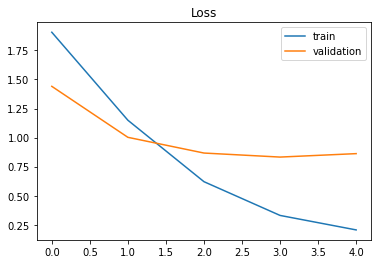

In [ ]:
plot_history(history.history['loss'], history.history['val_loss'])

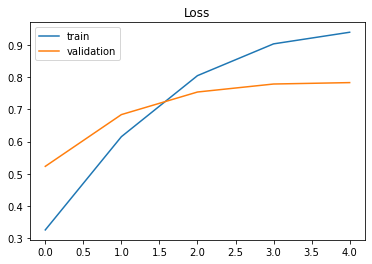

In [ ]:
plot_history(history.history['accuracy'], history.history['val_accuracy'])

In [ ]:
loss, accuracy = text_model1.evaluate(X_test, y_test)
print(f'Loss:     {loss}')
print(f'Accuracy: {accuracy}')

54/54 [==============================] - 8s 149ms/step - loss: 0.8568 - accuracy: 0.7706
Loss:     0.8568436503410339
Accuracy: 0.7705779075622559


In [ ]:
text_model1.save('task2_new_cnn')

INFO:tensorflow:Assets written to: task2_new_cnn/assets


INFO:tensorflow:Assets written to: task2_new_cnn/assets


In [ ]:
ls -R task2_new_cnn/

task2_new_cnn/:
assets/  saved_model.pb  variables/

task2_new_cnn/assets:

task2_new_cnn/variables:
variables.data-00000-of-00001  variables.index


In [ ]:
from google.colab import files
files.download('task2_new_cnn/saved_model.pb')
files.download('task2_new_cnn/variables/variables.index')
files.download('task2_new_cnn/variables/variables.data-00000-of-00001')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 3.1.2 RNN New Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Embedding, LSTM, GlobalMaxPooling1D, GlobalAveragePooling1D
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
max_features   = len(tokenizer.vocab) + 1
maxlen         = 865
embedding_dims = 500

def create_rnn_text():
  model = Sequential()
  model.add(Embedding(max_features, embedding_dims, input_length=maxlen))
  model.add(GlobalAveragePooling1D())
  model.add(Dense(200, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', 
                metrics=['accuracy'])
  return model

In [ ]:
text_model2 = create_rnn_text()
history     = text_model2.fit(X_train, y_train,
                              batch_size=32,
                              epochs=12,
                              validation_split=0.1)

Epoch 1/12
193/193 [==============================] - 127s 655ms/step - loss: 2.2534 - accuracy: 0.1853 - val_loss: 1.9472 - val_accuracy: 0.3076
Epoch 2/12
193/193 [==============================] - 125s 647ms/step - loss: 1.9056 - accuracy: 0.2818 - val_loss: 1.7605 - val_accuracy: 0.3499
Epoch 3/12
193/193 [==============================] - 125s 647ms/step - loss: 1.6874 - accuracy: 0.3699 - val_loss: 1.5835 - val_accuracy: 0.4257
Epoch 4/12
193/193 [==============================] - 125s 650ms/step - loss: 1.4534 - accuracy: 0.4755 - val_loss: 1.4362 - val_accuracy: 0.5087
Epoch 5/12
193/193 [==============================] - 125s 646ms/step - loss: 1.2246 - accuracy: 0.5958 - val_loss: 1.2086 - val_accuracy: 0.5991
Epoch 6/12
193/193 [==============================] - 125s 650ms/step - loss: 0.9624 - accuracy: 0.7014 - val_loss: 1.1395 - val_accuracy: 0.6254
Epoch 7/12
193/193 [==============================] - 126s 653ms/step - loss: 0.7865 - accuracy: 0.7604 - val_loss: 1.0746 -

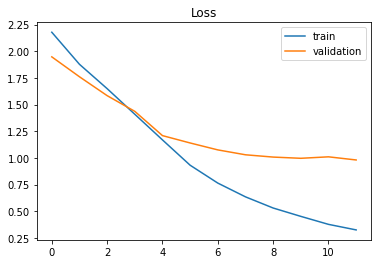

In [ ]:
plot_history(history.history['loss'], history.history['val_loss'])

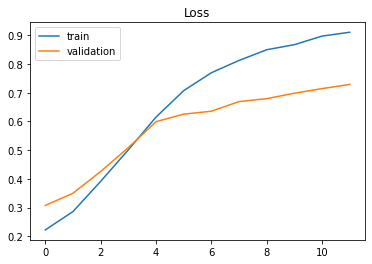

In [ ]:
plot_history(history.history['accuracy'], history.history['val_accuracy'])

In [ ]:
loss, accuracy = text_model2.evaluate(X_test, y_test)
print(f'Loss:     {loss}')
print(f'Accuracy: {accuracy}')

54/54 [==============================] - 1s 23ms/step - loss: 0.9481 - accuracy: 0.7507
Loss:     0.9481121897697449
Accuracy: 0.7507297396659851


In [ ]:
text_model2.save('task2_new_rnn.h5')

In [ ]:
from google.colab import files
files.download('task2_new_rnn.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 3.2.1 CNN Transfering Learning

In [ ]:
!mkdir -p task1_cnn_bert
!mkdir -p task1_cnn_bert/assets/
!mkdir -p task1_cnn_bert/variables/

In [ ]:
downloaded = drive.CreateFile({'id':"18iZftTT4ViiscU0xy217wedLNdCVG2zI"})
downloaded.GetContentFile('task1_cnn_bert/saved_model.pb')

downloaded = drive.CreateFile({'id':"1N2fsIgoNj6-44jp89lbAfxchVxTxgG33"})
downloaded.GetContentFile('task1_cnn_bert/variables/variables.index')
downloaded = drive.CreateFile({'id':"10LJ34Je-WkhKM4t8ZWQ2ElXyzGBgLxj5"})
downloaded.GetContentFile('task1_cnn_bert/variables/variables.data-00000-of-00001')

In [ ]:
import tensorflow as tf

base_model = tf.keras.models.load_model('task1_cnn_bert')
base_model.trainable = False
base_model.summary()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Embedding, Conv1D, GlobalMaxPooling1D
import tensorflow as tf

In [ ]:
x = base_model.layers[-2].output
x = tf.keras.layers.Dense(10, activation ='softmax')(x)
x

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_8')>

In [ ]:
text_model3 = tf.keras.models.Model(inputs=base_model.input, outputs=x)
text_model3.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_input (InputLayer) [(None, 1200)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 500)         59774000  
_________________________________________________________________
conv1d (Conv1D)              (None, 1199, 100)         100100    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1197, 100)         30100     
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                1616      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0  

In [ ]:
text_model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
len(text_model3.trainable_variables)

2

In [ ]:
history = text_model3.fit(X_train2, y_train, batch_size=32, epochs=5, validation_split=0.1)

Epoch 1/5
193/193 [==============================] - 44s 228ms/step - loss: 3.2519 - accuracy: 0.0957 - val_loss: 2.3708 - val_accuracy: 0.1880
Epoch 2/5
193/193 [==============================] - 44s 227ms/step - loss: 2.3288 - accuracy: 0.2065 - val_loss: 2.0413 - val_accuracy: 0.2668
Epoch 3/5
193/193 [==============================] - 44s 227ms/step - loss: 2.0144 - accuracy: 0.2958 - val_loss: 1.9104 - val_accuracy: 0.3178
Epoch 4/5
193/193 [==============================] - 44s 227ms/step - loss: 1.9029 - accuracy: 0.3155 - val_loss: 1.8509 - val_accuracy: 0.3324
Epoch 5/5
193/193 [==============================] - 44s 228ms/step - loss: 1.8370 - accuracy: 0.3392 - val_loss: 1.8134 - val_accuracy: 0.3455


In [ ]:
loss, accuracy = text_model3.evaluate(X_test2, y_test)
print(f'Loss:     {loss}')
print(f'Accuracy: {accuracy}')

54/54 [==============================] - 11s 206ms/step - loss: 1.7784 - accuracy: 0.3678
Loss:     1.7783734798431396
Accuracy: 0.3677758276462555


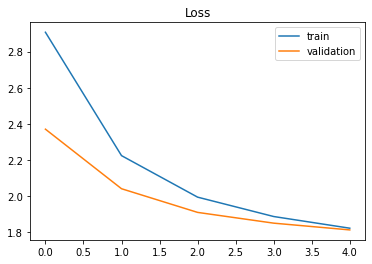

In [ ]:
plot_history(history.history['loss'], history.history['val_loss'])

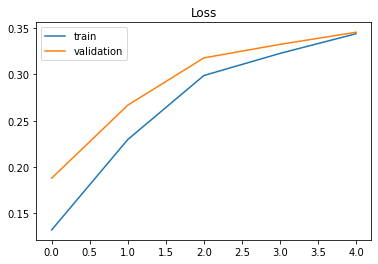

In [ ]:
plot_history(history.history['accuracy'], history.history['val_accuracy'])

In [ ]:
text_model3.save('task2_tl_cnn')

INFO:tensorflow:Assets written to: task2_tl_cnn/assets


INFO:tensorflow:Assets written to: task2_tl_cnn/assets


In [ ]:
ls -R task2_tl_cnn/

task2_tl_cnn/:
assets/  saved_model.pb  variables/

task2_tl_cnn/assets:

task2_tl_cnn/variables:
variables.data-00000-of-00001  variables.index


In [ ]:
from google.colab import files
files.download('task2_tl_cnn/saved_model.pb')
files.download('task2_tl_cnn/variables/variables.index')
files.download('task2_tl_cnn/variables/variables.data-00000-of-00001')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 3.2.2 RNN Transfering Learning

In [ ]:
downloaded = drive.CreateFile({'id':"1yjqwH_-UamZaK33pUMLkaluW34fxIBBT"})
downloaded.GetContentFile('task1_rnn_bert.h5')

In [ ]:
import tensorflow as tf

base_model = tf.keras.models.load_model('task1_rnn_bert.h5')
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1200, 500)         59774000  
_________________________________________________________________
global_average_pooling1d (Gl (None, 500)               0         
_________________________________________________________________
dense (Dense)                (None, 200)               100200    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1206      
Total params: 59,875,406
Trainable params: 59,875,406
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x = base_model.layers[-2].output
x = tf.keras.layers.Dense(10, activation ='softmax')(x)
x

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_9')>

In [ ]:
text_model4 = tf.keras.models.Model(inputs=base_model.input, outputs=x)
text_model4.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_input (InputLayer) [(None, 1200)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 500)         59774000  
_________________________________________________________________
global_average_pooling1d (Gl (None, 500)               0         
_________________________________________________________________
dense (Dense)                (None, 200)               100200    
_________________________________________________________________
dense_9 (Dense)              (None, 10)                2010      
Total params: 59,876,210
Trainable params: 59,876,210
Non-trainable params: 0
_________________________________________________________________


In [ ]:
text_model4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
len(text_model4.trainable_variables)

5

In [ ]:
history = text_model4.fit(X_train2, y_train, batch_size=32, 
                          epochs=5, validation_split=0.1)

Epoch 1/5
193/193 [==============================] - 132s 679ms/step - loss: 1.8864 - accuracy: 0.3239 - val_loss: 1.6176 - val_accuracy: 0.4388
Epoch 2/5
193/193 [==============================] - 136s 707ms/step - loss: 1.4806 - accuracy: 0.4905 - val_loss: 1.4355 - val_accuracy: 0.5102
Epoch 3/5
193/193 [==============================] - 130s 673ms/step - loss: 1.2282 - accuracy: 0.5817 - val_loss: 1.3616 - val_accuracy: 0.5335
Epoch 4/5
193/193 [==============================] - 128s 666ms/step - loss: 1.0294 - accuracy: 0.6627 - val_loss: 1.1948 - val_accuracy: 0.6254
Epoch 5/5
193/193 [==============================] - 128s 663ms/step - loss: 0.8720 - accuracy: 0.7159 - val_loss: 1.1802 - val_accuracy: 0.6224


In [ ]:
loss, accuracy = text_model4.evaluate(X_test2, y_test)
print(f'Loss:     {loss}')
print(f'Accuracy: {accuracy}')

54/54 [==============================] - 2s 33ms/step - loss: 1.1643 - accuracy: 0.6357
Loss:     1.1642916202545166
Accuracy: 0.635726809501648


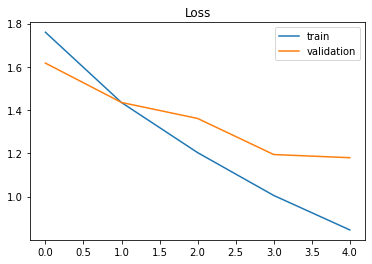

In [ ]:
plot_history(history.history['loss'], history.history['val_loss'])

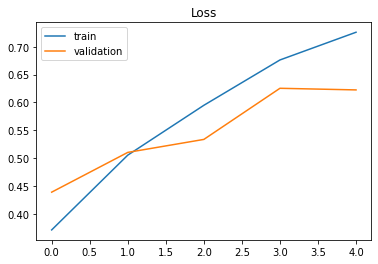

In [ ]:
plot_history(history.history['accuracy'], history.history['val_accuracy'])

In [ ]:
text_model4.save('task2_tl_rnn.h5')

In [ ]:
from google.colab import files
files.download('task2_tl_rnn.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 3.2.3 CNN Transfering Learning

In [ ]:
!mkdir -p task1_cnn_bert
!mkdir -p task1_cnn_bert/assets/
!mkdir -p task1_cnn_bert/variables/

In [ ]:
downloaded = drive.CreateFile({'id':"18iZftTT4ViiscU0xy217wedLNdCVG2zI"})
downloaded.GetContentFile('task1_cnn_bert/saved_model.pb')

downloaded = drive.CreateFile({'id':"1N2fsIgoNj6-44jp89lbAfxchVxTxgG33"})
downloaded.GetContentFile('task1_cnn_bert/variables/variables.index')
downloaded = drive.CreateFile({'id':"10LJ34Je-WkhKM4t8ZWQ2ElXyzGBgLxj5"})
downloaded.GetContentFile('task1_cnn_bert/variables/variables.data-00000-of-00001')

In [ ]:
import tensorflow as tf

base_model = tf.keras.models.load_model('task1_cnn_bert')
base_model.trainable = False
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1200, 500)         59774000  
_________________________________________________________________
conv1d (Conv1D)              (None, 1199, 100)         100100    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1197, 100)         30100     
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                1616      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Embedding, Conv1D, GlobalMaxPooling1D
import tensorflow as tf

In [ ]:
x = base_model.layers[-2].output
x = tf.keras.layers.Dense(10, activation ='softmax')(x)
x

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_8')>

In [ ]:
text_model3 = tf.keras.models.Model(inputs=base_model.input, outputs=x)
text_model3.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_input (InputLayer) [(None, 1200)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 500)         59774000  
_________________________________________________________________
conv1d (Conv1D)              (None, 1199, 100)         100100    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1197, 100)         30100     
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                1616      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0  

In [ ]:
text_model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
len(text_model3.trainable_variables)

2

In [ ]:
history = text_model3.fit(X_train2, y_train, batch_size=32, 
                          epochs=5, validation_split=0.1)

Epoch 1/5
193/193 [==============================] - 44s 228ms/step - loss: 3.2519 - accuracy: 0.0957 - val_loss: 2.3708 - val_accuracy: 0.1880
Epoch 2/5
193/193 [==============================] - 44s 227ms/step - loss: 2.3288 - accuracy: 0.2065 - val_loss: 2.0413 - val_accuracy: 0.2668
Epoch 3/5
193/193 [==============================] - 44s 227ms/step - loss: 2.0144 - accuracy: 0.2958 - val_loss: 1.9104 - val_accuracy: 0.3178
Epoch 4/5
193/193 [==============================] - 44s 227ms/step - loss: 1.9029 - accuracy: 0.3155 - val_loss: 1.8509 - val_accuracy: 0.3324
Epoch 5/5
193/193 [==============================] - 44s 228ms/step - loss: 1.8370 - accuracy: 0.3392 - val_loss: 1.8134 - val_accuracy: 0.3455


In [ ]:
loss, accuracy = text_model3.evaluate(X_test2, y_test)
print(f'Loss:     {loss}')
print(f'Accuracy: {accuracy}')

54/54 [==============================] - 11s 206ms/step - loss: 1.7784 - accuracy: 0.3678
Loss:     1.7783734798431396
Accuracy: 0.3677758276462555


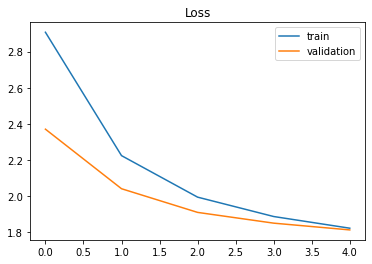

In [ ]:
plot_history(history.history['loss'], history.history['val_loss'])

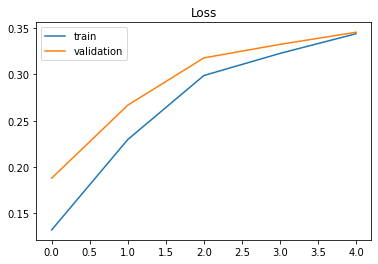

In [ ]:
plot_history(history.history['accuracy'], history.history['val_accuracy'])

In [ ]:
text_model3.save('task2_tl_cnn')

INFO:tensorflow:Assets written to: task2_tl_cnn/assets


INFO:tensorflow:Assets written to: task2_tl_cnn/assets


In [ ]:
ls -R task2_tl_cnn/

task2_tl_cnn/:
assets/  saved_model.pb  variables/

task2_tl_cnn/assets:

task2_tl_cnn/variables:
variables.data-00000-of-00001  variables.index


In [ ]:
from google.colab import files
files.download('task2_tl_cnn/saved_model.pb')
files.download('task2_tl_cnn/variables/variables.index')
files.download('task2_tl_cnn/variables/variables.data-00000-of-00001')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>